In [1]:
import tensorflow as tf, numpy as np, keras as K, sys
import keras.layers as L
from keras.models import Model, Sequential # keras/engine/training.py
from IPython import embed
import ipdb
import json
import sys
import time
import os

Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

print("Usage: ipython main.py [PredictMode?]")
print("Usage Predict Mode: ipython main.py 1 parameters Model.hdf5")
print("Usage Training Mode: ipython main.py 0 parameters")

Usage: ipython main.py [PredictMode?]
Usage Predict Mode: ipython main.py 1 parameters Model.hdf5
Usage Training Mode: ipython main.py 0 parameters


In [3]:
# GAME_NAME = sys.argv[1]
GAME_NAME = 'breakout'

if GAME_NAME == 'breakout':
    VAL_DATASET = ['519_AS_4083721_Jul-25-14-44-15', '528_AS_4154228_Jul-26-10-19-49', '530_AS_4157852_Jul-26-11-21-03', '567_AS_4670551_Aug-01-09-43-43', '569_AS_4673908_Aug-01-10-41-22', '579_AS_4763410_Aug-02-11-33-15', '581_AS_4767279_Aug-02-12-35-31']
    BASE_FILE_NAME = "/home/akanksha/learning-rewards-of-learners/data/novice-atari-head/breakout"  
    MODEL_DIR = "pretrained_models/breakout"

elif GAME_NAME == 'enduro':
    VAL_DATASET = ['632_KD_5885878_Aug-15-11-18-48', '634_KD_5890143_Aug-15-12-29-52', '635_KD_5891253_Aug-15-12-48-24', '636_KD_5892408_Aug-15-13-07-37']
    BASE_FILE_NAME = "/home/akanksha/learning-rewards-of-learners/data/novice-atari-head/enduro"  
    MODEL_DIR = "pretrained_models/enduro"

elif GAME_NAME == 'hero':
    VAL_DATASET = ['517_KD_4079831_Jul-25-13-39-39', '518_KD_4081171_Jul-25-14-05-39', '545_KD_4504850_Jul-30-11-41-56', '547_KD_4508017_Jul-30-12-34-28']
    BASE_FILE_NAME = "/home/akanksha/learning-rewards-of-learners/data/novice-atari-head/hero"  
    MODEL_DIR = "pretrained_models/hero"

elif GAME_NAME == 'seaquest':
    VAL_DATASET = ['555_KD_4589264_Jul-31-11-09-29', '557_KD_4592060_Jul-31-11-55-20', '559_KD_4595259_Jul-31-12-48-41', '625_KD_5877001_Aug-15-08-51-03', '627_KD_5879901_Aug-15-09-40-24', '630_KD_5882801_Aug-15-10-29-24', '633_KD_5887251_Aug-15-11-41-40']
    BASE_FILE_NAME = "/home/akanksha/learning-rewards-of-learners/data/novice-atari-head/seaquest"  
    MODEL_DIR = "pretrained_models/seaquest"
    
elif GAME_NAME == 'space_invaders':
    VAL_DATASET = ['644_KD_7692518_Sep-05-09-09-52', '645_AS_7693827_Sep-05-09-31-21', '646_AS_7695048_Sep-05-09-51-40', '647_AS_7696170_Sep-05-10-10-20']
    BASE_FILE_NAME = "/home/akanksha/learning-rewards-of-learners/data/novice-atari-head/spaceinvaders"  
    MODEL_DIR = "pretrained_models/space_invaders"


In [4]:
LABELS_FILE_TRAIN = BASE_FILE_NAME + '-train.txt' 
LABELS_FILE_VAL =  BASE_FILE_NAME + '-val.txt' 
GAZE_POS_ASC_FILE = BASE_FILE_NAME + '.asc'
AFFIX = '-image_past4'
PREDICT_FILE_VAL = BASE_FILE_NAME.split('/')[-1] + AFFIX
BATCH_SIZE = 32
num_epoch = 50

resume_model = False
predict_mode = 1 #int(sys.argv[2]) 
dropout = 0.5#float(sys.argv[3])
heatmap_shape = 84
k = 4
stride = 1
SHAPE = (84,84,k) # height * width * channel This cannot read from file and needs to be provided here

import input_utils as IU, misc_utils as MU
# if not predict_mode: # if train
#     expr = MU.BMU.ExprCreaterAndResumer(MODEL_DIR, postfix="pKf_dp%.1f_k%ds%d" % (dropout,k,stride))
#     expr.redirect_output_to_logfile_if_not_on("eldar-11")

MU.BMU.save_GPU_mem_keras()
MU.keras_model_serialization_bug_fix()

if resume_model:
    model = expr.load_weight_and_training_config_and_state()
    expr.printdebug("Checkpoint found. Resuming model at %s" % expr.dir_lasttime)
else:
    ###############################
    # Architecture of the network #
    ###############################

    inputs=L.Input(shape=SHAPE)
    x=inputs # inputs is used by the line "Model(inputs, ... )" below
    
    conv1=L.Conv2D(32, (8,8), strides=4, padding='valid')
    x = conv1(x)
    print(conv1.output_shape)
    x=L.Activation('relu')(x)
    x=L.BatchNormalization()(x)
    x=L.Dropout(dropout)(x)
    
    conv2=L.Conv2D(64, (4,4), strides=2, padding='valid')
    x = conv2(x)
    print(conv2.output_shape)
    x=L.Activation('relu')(x)
    x=L.BatchNormalization()(x)
    x=L.Dropout(dropout)(x)
    
    conv3=L.Conv2D(64, (3,3), strides=1, padding='valid')
    x = conv3(x)
    print(conv3.output_shape)
    x=L.Activation('relu')(x)
    x=L.BatchNormalization()(x)
    x=L.Dropout(dropout)(x)
    
    deconv1 = L.Conv2DTranspose(64, (3,3), strides=1, padding='valid')
    x = deconv1(x)
    print(deconv1.output_shape)
    x=L.Activation('relu')(x)
    x=L.BatchNormalization()(x)
    x=L.Dropout(dropout)(x)

    deconv2 = L.Conv2DTranspose(32, (4,4), strides=2, padding='valid')
    x = deconv2(x)
    print(deconv2.output_shape)
    x=L.Activation('relu')(x)
    x=L.BatchNormalization()(x)
    x=L.Dropout(dropout)(x)         

    deconv3 = L.Conv2DTranspose(1, (8,8), strides=4, padding='valid')
    x = deconv3(x)
    print(deconv3.output_shape)
#    x=L.Activation('relu')(x)
#    x=L.BatchNormalization()(x)

    outputs = L.Activation(MU.my_softmax)(x)

    model=Model(inputs=inputs, outputs=outputs)

    opt=K.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
    #opt=K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 

    model.compile(loss=MU.my_kld, optimizer=opt, metrics=[MU.NSS])
    #model.compile(loss=K.losses.kullback_leibler_divergence, optimizer=opt, metrics=[MU.NSS])
    


(None, 20, 20, 32)
(None, 9, 9, 64)
(None, 7, 7, 64)
(None, 9, 9, 64)
(None, 20, 20, 32)
(None, 84, 84, 1)
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
# d=IU.DatasetWithHeatmap_PastKFrames(LABELS_FILE_TRAIN, LABELS_FILE_VAL, SHAPE, heatmap_shape, GAZE_POS_ASC_FILE, k, stride)

# if not predict_mode: # if train
#     expr.dump_src_code_and_model_def(sys.argv[0], model)

#     model.fit(d.train_imgs, d.train_GHmap, BATCH_SIZE, epochs=num_epoch,
#         validation_data=(d.val_imgs, d.val_GHmap, d.val_weight),
#         shuffle=True, sample_weight=d.train_weight, verbose=2,
#         callbacks=[K.callbacks.TensorBoard(log_dir=expr.dir),
#             K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr = 0.00001),
#             MU.BMU.PrintLrCallback()])
    
#     expr.save_weight_and_training_config_state(model)

#     score = model.evaluate(d.val_imgs, d.val_GHmap, BATCH_SIZE, 0, sample_weight=d.val_weight)
#     expr.printdebug("eval score:" + str(score))
import os.path as path
import cv2
import copy
from scipy import misc

meanfile = 'pretrained_models/breakout.mean.npy'
mean = np.load(meanfile)

img_dir = path.join(BASE_FILE_NAME, VAL_DATASET[0])
stacked = []
stacked_obs = np.zeros((84,84,4))
for i in range(55,59):
    obs = cv2.imread(img_dir+'/AS_4083721_'+str(i)+'.png')
    print(img_dir+'/AS_4083721_'+str(i)+'.png')
    
#     gray = cv2.cvtColor(obs, cv2.COLOR_BGR2GRAY)
#     resized_image = cv2.resize(gray, (84, 84)) 
#     stacked_obs[:,:,i-55] = resized_image
    
    img_np = np.dot(obs, [0.299, 0.587, 0.114]) # convert to grayscale
    img_np = misc.imresize(img_np, [84, 84], interp='bilinear')
    img_np = np.expand_dims(img_np, axis=2)
    img_np = img_np.astype(np.float32) / 255.0
    img_np -= mean
    print(img_np.shape)
    stacked_obs[:,:,i-55] = img_np.squeeze()
    
stacked_obs = np.expand_dims(stacked_obs, axis=0)

# stacked.append(np.expand_dims(copy.deepcopy(stacked_obs),0))
# print(stacked_obs)
print(stacked_obs.shape)

if predict_mode: # if predict
    # model.load_weights(sys.argv[4])
    model.load_weights('pretrained_models/breakout.hdf5')

#     print "Evaluating model..."
#     #train_score = model.evaluate(d.train_imgs, d.train_GHmap, BATCH_SIZE, 0)
#     #print "Train loss is:  " , train_score
#     val_score = model.evaluate(d.val_imgs, d.val_GHmap, BATCH_SIZE, 0, d.val_weight)
#     print "Val loss is: " , val_score

    BATCH_SIZE = 1
    print("Predicting results...")
#     train_pred = model.predict(d.train_imgs, BATCH_SIZE) # [1] for prob
#     val_pred = model.predict(d.val_imgs, BATCH_SIZE)
    val_predict = model.predict(stacked_obs)
    print("Predicted.")
    
    print(val_predict.squeeze().shape)
    print(val_predict)
#     cv2.imshow('prediction', val_predict.squeeze())
#     cv2.waitKey(0)
    
    # Uncomment this block to save predicted gaze heatmap for visualization
    # print "Converting predicted results into png files and save..."
    # IU.save_heatmap_png_files(d.train_fid, train_pred, TRAIN_DATASET, 'saliency/')
    # IU.save_heatmap_png_files(d.val_fid, val_pred, VAL_DATASET, 'saliency/')
    # print "Done."

#     print "Writing predicted gaze heatmap (train) into the npz file..."
#     np.savez_compressed(BASE_FILE_NAME.split('/')[-1] + '-train' + AFFIX, fid=d.train_fid, heatmap=train_pred)
#     print "Done. Output is:"
#     print " %s" % BASE_FILE_NAME.split('/')[-1] + '-train' + AFFIX + '.npz'

#     print "Writing predicted gaze heatmap (val) into the npz file..."
#     np.savez_compressed(BASE_FILE_NAME.split('/')[-1] + '-val' + AFFIX, fid=d.val_fid, heatmap=val_pred)
#     print "Done. Output is:"
#     print " %s" % BASE_FILE_NAME.split('/')[-1] + '-val' + AFFIX + '.npz'


/home/akanksha/learning-rewards-of-learners/data/novice-atari-head/breakout/519_AS_4083721_Jul-25-14-44-15/AS_4083721_55.png
(84, 84, 1)
/home/akanksha/learning-rewards-of-learners/data/novice-atari-head/breakout/519_AS_4083721_Jul-25-14-44-15/AS_4083721_56.png
(84, 84, 1)
/home/akanksha/learning-rewards-of-learners/data/novice-atari-head/breakout/519_AS_4083721_Jul-25-14-44-15/AS_4083721_57.png
(84, 84, 1)
/home/akanksha/learning-rewards-of-learners/data/novice-atari-head/breakout/519_AS_4083721_Jul-25-14-44-15/AS_4083721_58.png
(84, 84, 1)
(1, 84, 84, 4)


/home/akanksha/.virtualenv/t-rex/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Predicting results...
Predicted.
(84, 84)
[[[[3.14907265e-06]
   [2.61228956e-06]
   [2.47804564e-06]
   ...
   [7.38521294e-06]
   [8.54620885e-06]
   [1.11852196e-05]]

  [[2.60886600e-06]
   [2.12145142e-06]
   [2.01112380e-06]
   ...
   [5.82150051e-06]
   [6.82292330e-06]
   [9.09638129e-06]]

  [[2.32477350e-06]
   [1.86854618e-06]
   [1.77371078e-06]
   ...
   [4.77292679e-06]
   [5.65563369e-06]
   [7.63687149e-06]]

  ...

  [[1.25065644e-05]
   [1.04715282e-05]
   [9.69394114e-06]
   ...
   [1.12234084e-05]
   [1.23443360e-05]
   [1.52385701e-05]]

  [[1.34848879e-05]
   [1.13748756e-05]
   [1.06124935e-05]
   ...
   [1.25244323e-05]
   [1.37123607e-05]
   [1.67864473e-05]]

  [[1.61686003e-05]
   [1.38764244e-05]
   [1.31043744e-05]
   ...
   [1.56342121e-05]
   [1.69577215e-05]
   [2.03931904e-05]]]]


In [6]:
# import vip_constants as V
# import pygame
# from pygame.constants import RESIZABLE,DOUBLEBUF,RLEACCEL

# pygame.init()
# pygame.display.set_mode((V.SCR_W, V.SCR_H), RESIZABLE | DOUBLEBUF | RLEACCEL, 32)
# screen = pygame.display.get_surface()

# if val_predict is not None:
#     GHmap = val_predict.squeeze().transpose([1,0])
#     print(GHmap.max())
#     GHmap1 = GHmap / GHmap.max() * 255.0
#     print(GHmap.max())
#     GHmap = GHmap1.astype(np.int8)
#     print(GHmap.max())
#     print(GHmap.min())
#     GHmap3 = np.repeat(GHmap[..., np.newaxis], 3, axis=-1)
#     print(GHmap3.max())
#     print(GHmap3.min())
# #     cv2.imshow('prediction', GHmap)
# #     cv2.waitKey(0)
#     s = pygame.surfarray.make_surface(GHmap3)
#     s.set_alpha(100)
#     s = pygame.transform.scale(s, (V.SCR_W, V.SCR_H))
#     screen.blit(s, (0,0))
# #     print(GHmap)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
0.0023584545
0.0023584545
127
-128
127
-128


0.0023584545
255.0
127


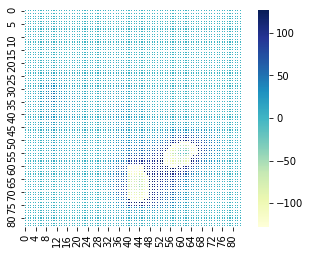

In [9]:
import seaborn as sns
import matplotlib.pylab as plt

GHmap = val_predict.squeeze().transpose([1,0])
print(GHmap.max())
GHmap = GHmap / GHmap.max() * 255.0
print(GHmap.max())
GHmap = GHmap.astype(np.int8)
print(GHmap.max())

ax = sns.heatmap(GHmap, linewidth=0.5, square=True,  cmap="YlGnBu")
plt.show()

In [10]:

GHmap = val_predict.squeeze().transpose([1,0])
print(GHmap.max())
GHmap1 = (GHmap - GHmap.min()) / (GHmap.max()-GHmap.min()) * 255.0
print(GHmap.max())
GHmap = GHmap1.astype(np.uint8)
print(GHmap.max())
print(GHmap.min())
GHmap3 = np.repeat(GHmap[..., np.newaxis], 3, axis=-1)
print(GHmap3.max())
print(GHmap3.min())

print(obs.shape)
print(GHmap3.shape)
# gray = cv2.cvtColor(obs, cv2.COLOR_BGR2GRAY)
resized_map = cv2.resize(GHmap3.astype(np.uint8), (160, 210)) 
print(type(resized_map[0,0,0]))
print(type(obs[0,0,0]))

print(obs.shape)
print(resized_map.shape)

fin = cv2.addWeighted(resized_map, 0.7, obs, 0.3, 0)


0.0023584545
0.0023584545
255
0
255
0
(210, 160, 3)
(84, 84, 3)
<class 'numpy.uint8'>
<class 'numpy.uint8'>
(210, 160, 3)
(210, 160, 3)


In [ ]:
cv2.imshow('blended',fin)
cv2.waitKey(0)


In [ ]:
cv2.destroyAllWindows()